In [3]:
import pandas as pd
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
import seaborn as sns
import isodate

plt.style.use('ggplot')
sns.set_palette('Set2')


In [4]:
API_KEY = 'YOUR KEY'
def fetch_trending_videos(api_key, num_results=200):
    youtube_service = build('youtube', 'v3', developerKey=api_key)
    trending_videos_list = []
    request = youtube_service.videos().list(
        part='snippet,contentDetails,statistics',
        chart='mostPopular',
        regionCode='US',
        maxResults=50
    )
    while request and len(trending_videos_list) < num_results:
        response = request.execute()
        for video in response['items']:
            video_info = {
                'video_id': video['id'],
                'title': video['snippet']['title'],
                'description': video['snippet'].get('description', 'No description'),
                'published_at': video['snippet']['publishedAt'],
                'channel_id': video['snippet']['channelId'],
                'channel_title': video['snippet']['channelTitle'],
                'category_id': video['snippet']['categoryId'],
                'tags': video['snippet'].get('tags', []),
                'duration': video['contentDetails']['duration'],
                'definition': video['contentDetails']['definition'],
                'caption': video['contentDetails'].get('caption', False),
                'view_count': video['statistics'].get('viewCount', 0),
                'like_count': video['statistics'].get('likeCount', 0),
                'comment_count': video['statistics'].get('commentCount', 0)
            }
            trending_videos_list.append(video_info)
        request = youtube_service.videos().list_next(request, response)
    return trending_videos_list[:num_results]

def export_to_csv(video_data, file_name):
    df = pd.DataFrame(video_data)
    df.to_csv(file_name, index=False)

videos = fetch_trending_videos(API_KEY)
csv_file = 'youtube_trending_videos.csv'
export_to_csv(videos, csv_file)

# Load the CSV file into a DataFrame
trending_videos_df = pd.read_csv(csv_file)
trending_videos_df.head()


,video_id,title,description,published_at,channel_id,channel_title,category_id,tags,duration,definition,caption,view_count,like_count,comment_count
0,v-94Snw-H4o,Marvel Studios’ Thunderbolts* | Teaser Trailer...,Careful who you assemble. Marvel Studios’ #Thu...,2024-09-23T13:00:02Z,UCvC4D8onUfXzvjTOM-dBfEA,Marvel Entertainment,24,"['marvel', 'comics']",PT3M25S,hd,True,11179411,402392,25850
1,IBlbMliEd84,The Biggest Storm Of The Year Is Coming...,"In this video, we explore severe weather threa...",2024-09-23T17:12:53Z,UCJHAT3Uvv-g3I8H3GhHWV7w,"Ryan Hall, Y'all",24,"['weather', 'weather forecasting', 'forecastin...",PT12M57S,hd,True,966137,40297,1590
2,Ts0N8swyWFI,Gladiator II | New Trailer (2024 Movie) - Paul...,"From director Ridley Scott, watch the New Trai...",2024-09-23T13:00:20Z,UCF9imwPMSGz4Vq1NiTWCC7g,Paramount Pictures,1,[],PT2M33S,hd,True,6709702,18303,2403
3,MRtg6A1f2Ko,iPhone 16/16 Pro Review: Times Have Changed!,iPhone 16 is here. Job finished? Job ain't fin...,2024-09-23T23:23:20Z,UCBJycsmduvYEL83R_U4JriQ,Marques Brownlee,28,"['iPhone 16', 'iPhone 16 review', 'MKBHD', 'MK...",PT20M41S,hd,True,2441489,96050,11161
4,56EyKNjhUDY,Everybody wants to waste your time,Thanks to SoFi for sponsoring the video! Enter...,2024-09-22T18:33:05Z,UCTSRIY3GLFYIpkR2QwyeklA,Drew Gooden,23,"['drew gooden', 'comedy', 'commentary', 'react...",PT30M31S,hd,True,2082345,166559,10644


In [5]:
missing_data = trending_videos_df.isnull().sum()
print(f"Missing data in each column:\n{missing_data}")

print("Descriptive statistics of key engagement metrics:")
print(trending_videos_df[['view_count', 'like_count', 'comment_count']].describe())


Missing data in each column:
video_id         0
title            0
description      1
published_at     0
channel_id       0
channel_title    0
category_id      0
tags             0
duration         0
definition       0
caption          0
view_count       0
like_count       0
comment_count    0
dtype: int64
Descriptive statistics of key engagement metrics:
         view_count    like_count  comment_count
count  2.000000e+02  2.000000e+02     200.000000
mean   2.051764e+06  7.245972e+04    4621.140000
std    7.727772e+06  2.520746e+05   10451.685661
min    3.845300e+04  5.210000e+02       0.000000
25%    3.166558e+05  9.818500e+03     858.500000
50%    6.359930e+05  2.394400e+04    1673.000000
75%    1.360046e+06  5.963875e+04    4315.000000
max    1.045498e+08  3.363712e+06   93175.000000


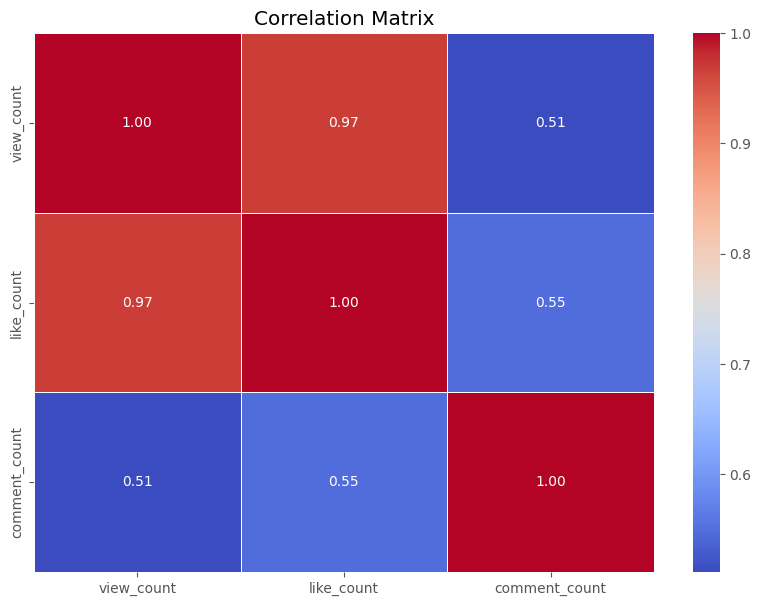

In [6]:
corr_matrix = trending_videos_df[['view_count', 'like_count', 'comment_count']].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


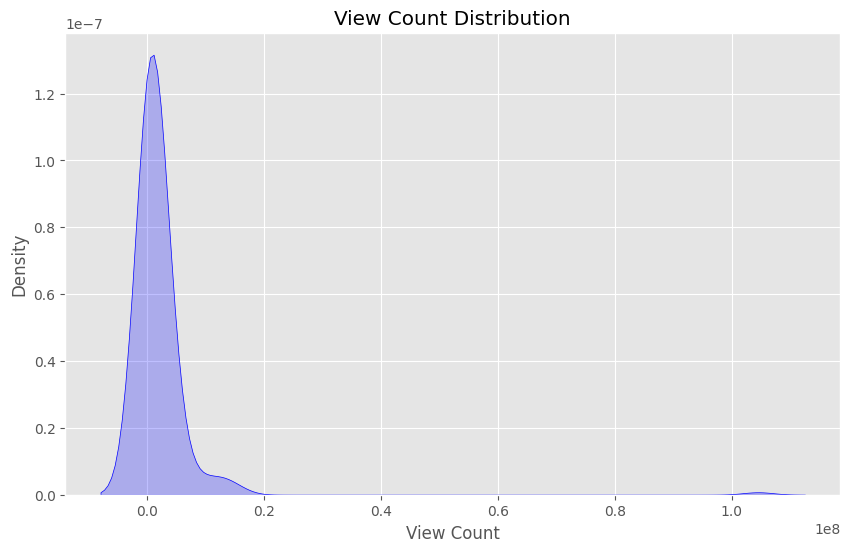

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(trending_videos_df['view_count'], color='blue', fill=True)
plt.title('View Count Distribution')
plt.xlabel('View Count')
plt.ylabel('Density')
plt.show()

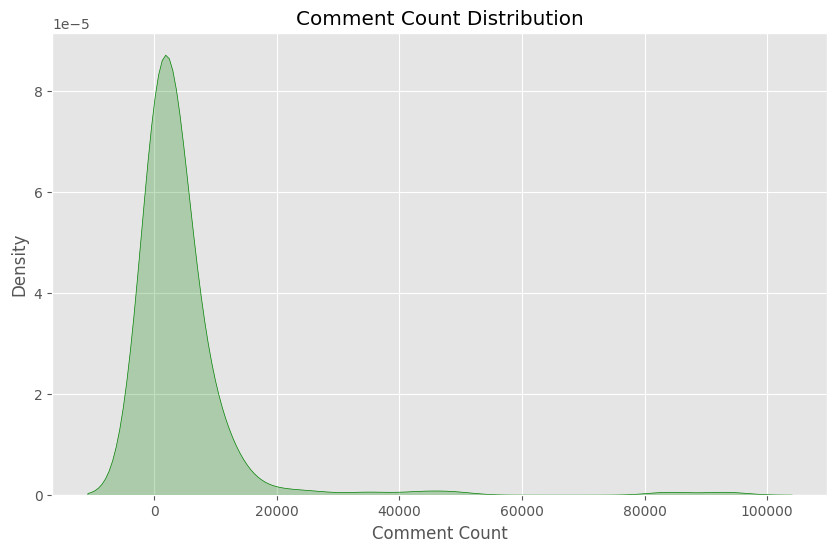

In [10]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=trending_videos_df['comment_count'], color='green',fill=True)
plt.title('Comment Count Distribution')
plt.xlabel('Comment Count')
plt.show()

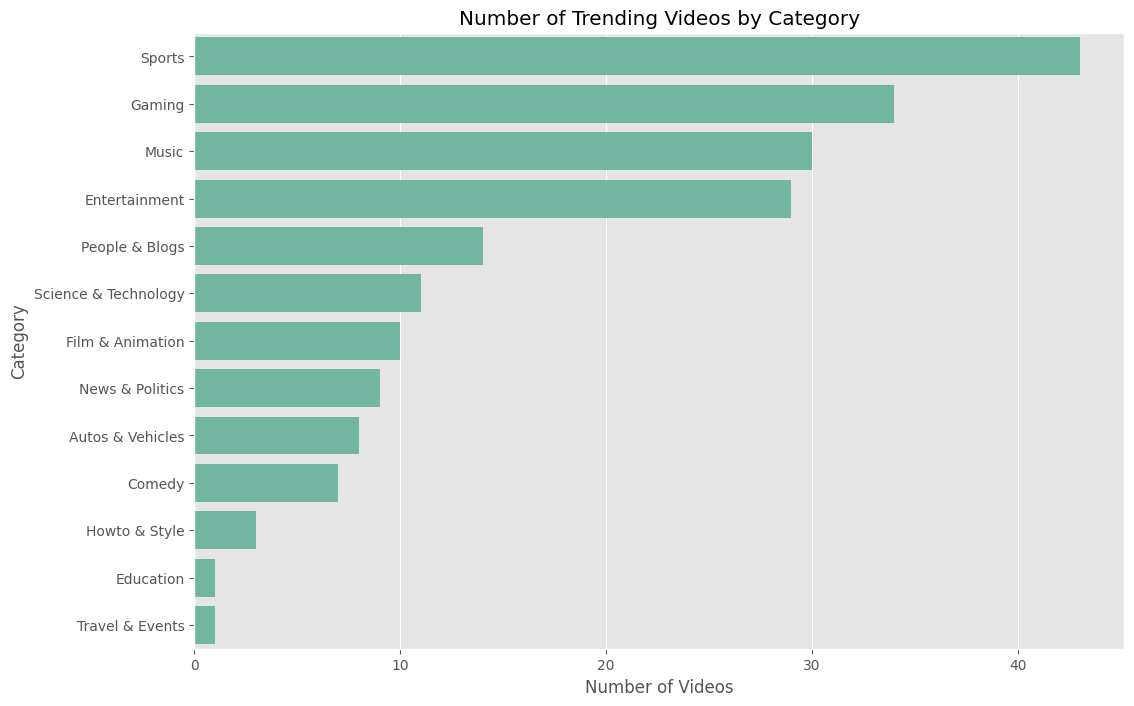

In [12]:
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(part='snippet', regionCode='US')
    response = request.execute()
    category_mapping = {int(item['id']): item['snippet']['title'] for item in response['items']}
    return category_mapping

category_mapping = get_category_mapping()
trending_videos_df['category_name'] = trending_videos_df['category_id'].map(category_mapping)

plt.figure(figsize=(12, 8))
sns.countplot(y=trending_videos_df['category_name'], order=trending_videos_df['category_name'].value_counts().index)
plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()


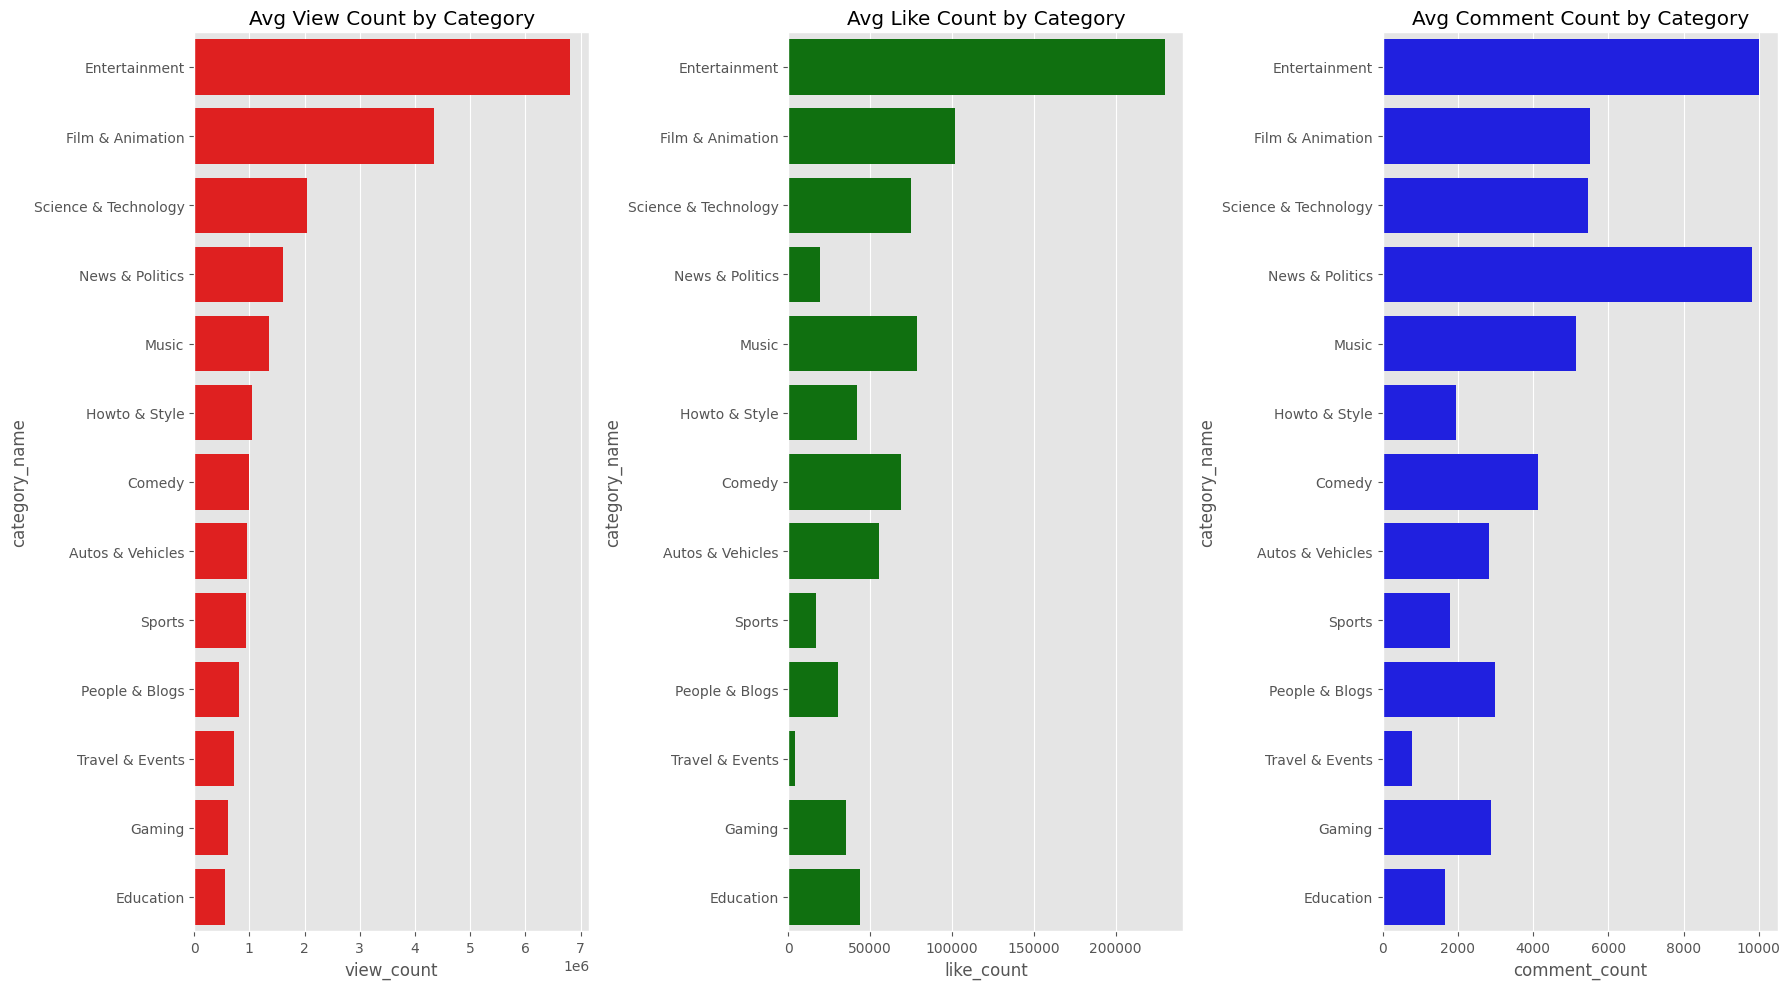

In [17]:
category_engagement = trending_videos_df.groupby('category_name')[['view_count', 'like_count', 'comment_count']].mean().sort_values(by='view_count', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], color='r')
axes[0].set_title('Avg View Count by Category')

sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1],color='g')
axes[1].set_title('Avg Like Count by Category')

sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2],color='b')
axes[2].set_title('Avg Comment Count by Category')

plt.tight_layout()
plt.show()


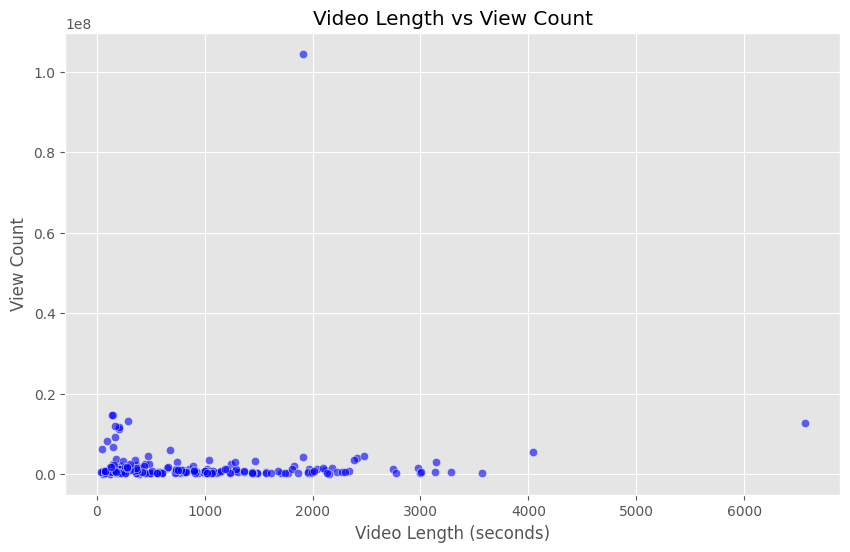

In [21]:
trending_videos_df['duration_seconds'] = trending_videos_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos_df['duration_range'] = pd.cut(trending_videos_df['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos_df, alpha=0.6, color='blue')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()


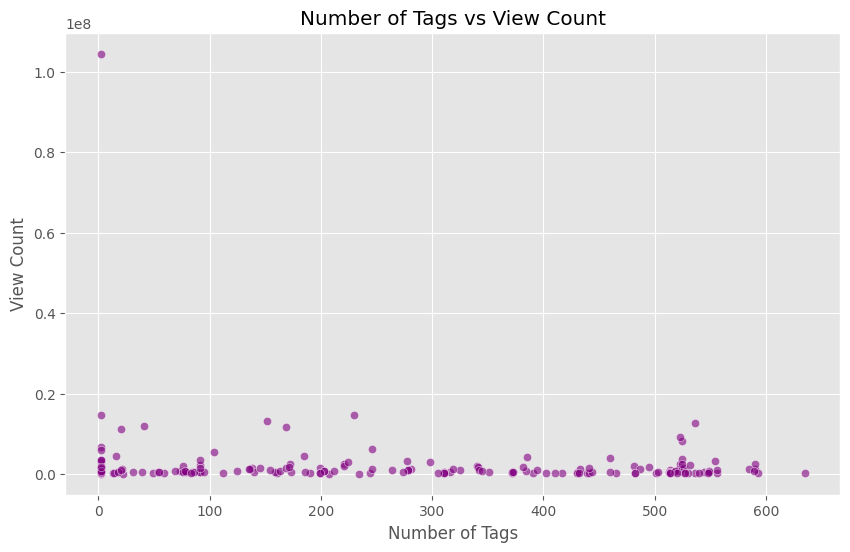

In [20]:
trending_videos_df['tag_count'] = trending_videos_df['tags'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tag_count', y='view_count', data=trending_videos_df, alpha=0.6, color='purple')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()


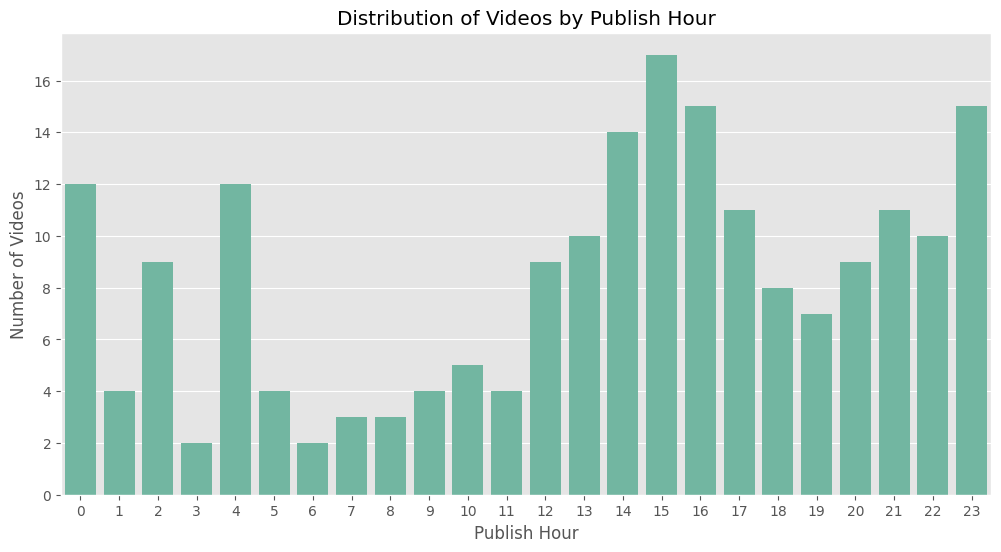

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='publish_hour', data=trending_videos_df)
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()


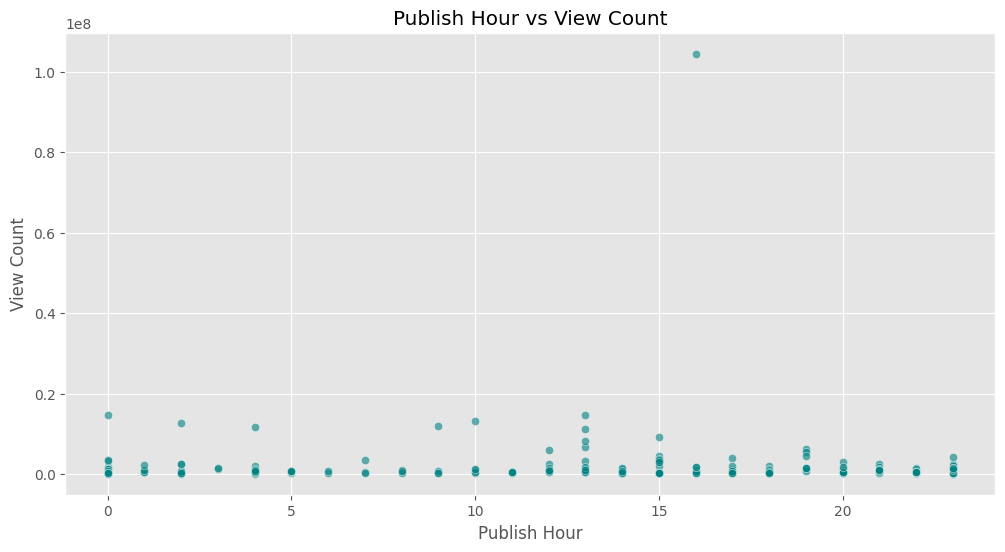

In [22]:
trending_videos_df['published_at'] = pd.to_datetime(trending_videos_df['published_at'])
trending_videos_df['publish_hour'] = trending_videos_df['published_at'].dt.hour

plt.figure(figsize=(12, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos_df, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()
